In [1]:
import _init_paths
from glob import glob
import cv2
import numpy as np
import pandas as pd

import torch.utils.data as data

In [2]:
from datasets.dataset.wheat import Wheat
from datasets.dataset_factory import get_dataset

In [3]:
from opts import opts
opt = opts()
opt.input_res = 1024
opt.input_h = 1024
opt.input_w = 1024
opt.down_ratio = 4
opt.task = 'ctdet'
opt.cat_spec_wh = False
opt.reg_offset = True
opt.data_dir = '../data'
opt.keep_res = False
opt.not_rand_crop = True
opt.flip = True
opt.no_color_aug = False
opt.mse_loss = False
opt.heatmap_wh = True
opt.dense_wh = False
opt.large_scale = False

opt.crop_size = 768
opt.not_rand_crop = True
opt.scale = 0.
opt.shift = 0.
opt.rotate = 15.
opt.shear = 5.

opt.mosaic = True
opt.debug = True

In [4]:
Dataset = get_dataset('wheat', opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)

heads {'hm': 1, 'wh': 2, 'reg': 2}


In [5]:
ds = Dataset(opt, 'train')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
==> initializing data dictionary...
Loaded train 2698 samples


In [6]:
print(ds.mean)
print(ds.std)

[[[0.31529  0.317253 0.214556]]]
[[[0.245211 0.238036 0.193879]]]


In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'][:, :, ::-1].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

category_id_to_name = {0: 'wheat'}

In [8]:
def xywh2xyxy(bboxes):
    result = []
    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        x *= 4
        y *= 4
        w *= 4
        h *= 4
        x_min = int((x - w/2))
        y_min = int((y - h/2))
        x_max = int(x_min + w)
        y_max = int(y_min + h)
        result.append([x_min, y_min, x_max, y_max])
    return result

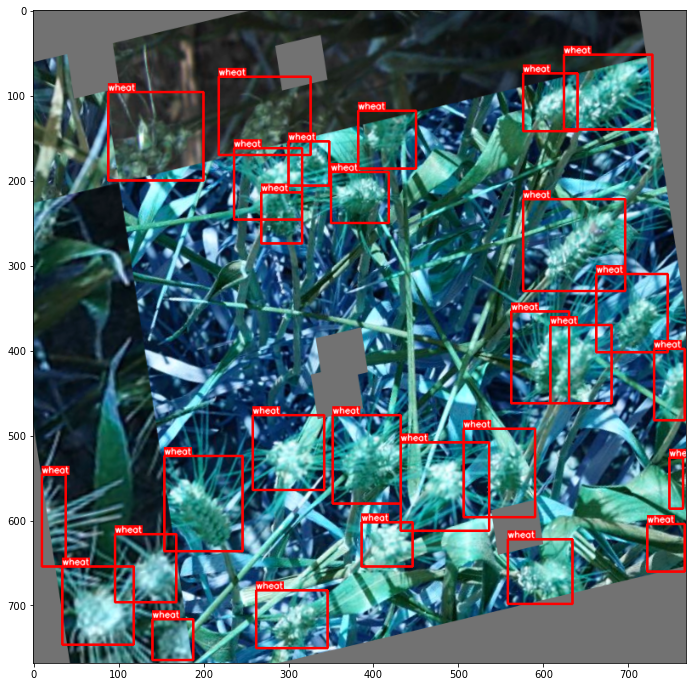

In [24]:
o = ds[-1]
image = (((o['input'].transpose(1, 2, 0) * ds.std) + ds.mean) * 255).astype(np.uint8)
boxes = o['meta']['labels'][:, 1:5].astype(np.int32)
boxes = xywh2xyxy(boxes)
visualize({'image': image, 'bboxes':boxes, 'category_id': [0] * len(boxes)}, category_id_to_name)

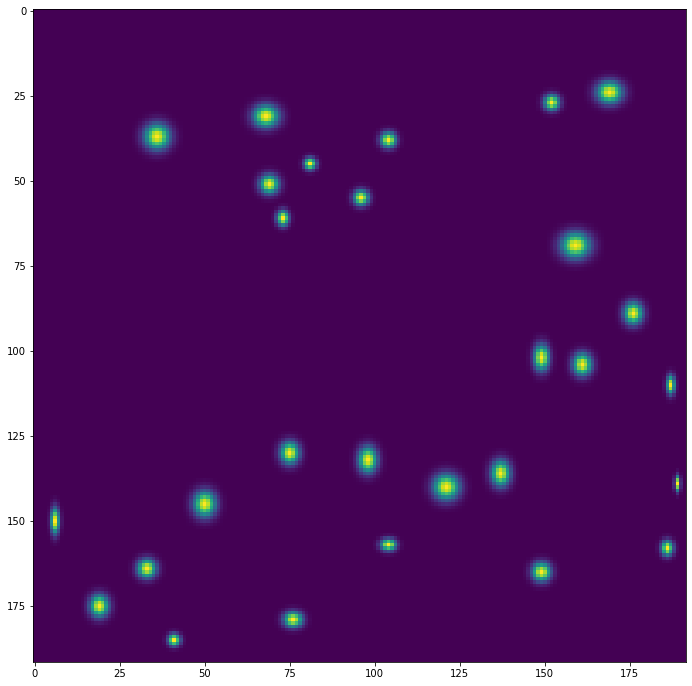

In [25]:
plt.figure(figsize=(12,12))
plt.imshow(o['hm'][0])
plt.show()

In [ ]:
import os
import torch
import json
from wheat_infer_utils import *

In [ ]:
class WheatDatasetTest(torch.utils.data.Dataset):
    def __init__(self, opt, image_dir, img_id):
        
        self.opt = opt
        
        self.image_dir = image_dir
        self.img_id = img_id
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.img_id[idx])
        return img_path, self.img_id[idx]

In [ ]:
with open('../data/wheat/annotations/train.json', 'r') as f:
    val_data_dict = json.load(f)
val_img_ids = [d['file_name'] for d in val_data_dict['images']]

In [ ]:
testdataset = WheatDatasetTest(opt, '../data/wheat/images', val_img_ids)
print('Total number of images in valid set: {}'.format(len(testdataset)))

In [ ]:
opt.mean = [0.214556, 0.317253, 0.315290]
opt.std = [0.193879, 0.238036, 0.245211]

opt.test_scales = 1
opt.fix_res = False
opt.pad = 0
opt.flip_test = False

In [ ]:
class BaseDetector(object):
    def __init__(self, opt):

        self.mean = np.array(opt.mean, dtype=np.float32).reshape(1, 1, 3)
        self.std = np.array(opt.std, dtype=np.float32).reshape(1, 1, 3)
        self.num_classes = opt.num_classes
        self.scales = opt.test_scales
        self.opt = opt
        self.pause = True

    def pre_process(self, image, scale, meta=None):
        height, width = image.shape[0:2]
        new_height = int(height * scale)
        new_width  = int(width * scale)
        if self.opt.fix_res:
            inp_height, inp_width = self.opt.input_h, self.opt.input_w
            c = np.array([new_width / 2., new_height / 2.], dtype=np.float32)
            s = max(height, width) * 1.0
        else:
            inp_height = (new_height | self.opt.pad) + 1
            inp_width = (new_width | self.opt.pad) + 1
            c = np.array([new_width // 2, new_height // 2], dtype=np.float32)
            s = np.array([inp_width, inp_height], dtype=np.float32)

        trans_input = get_affine_transform(c, s, 0, [inp_width, inp_height])
        resized_image = cv2.resize(image, (new_width, new_height))
        inp_image = cv2.warpAffine(
            resized_image, trans_input, (inp_width, inp_height),
            flags=cv2.INTER_LINEAR)
        inp_image = ((inp_image / 255. - self.mean) / self.std).astype(np.float32)

        images = inp_image.transpose(2, 0, 1).reshape(1, 3, inp_height, inp_width)
        if self.opt.flip_test:
            images = np.concatenate((images, images[:, :, :, ::-1]), axis=0)
        images = torch.from_numpy(images)
        meta = {'c': c, 's': s, 
                'out_height': inp_height // self.opt.down_ratio, 
                'out_width': inp_width // self.opt.down_ratio}
        return images, meta

In [ ]:
detector = BaseDetector(opt)

In [ ]:
img_path = testdataset[0][0]
img_path = '../data/wheat/images\\ffdf83e42.jpg'
image = cv2.imread(img_path)
img_path

In [ ]:
inp, meta = detector.pre_process(image, 1)

In [ ]:
inp_reverse = (((inp[0].numpy().transpose(1, 2, 0) * ds.std) + ds.mean) * 255).astype(np.uint8)
inp_reverse =  cv2.cvtColor(inp_reverse, cv2.COLOR_BGR2RGB)

%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(inp_reverse)
plt.show()